# Downside Measures: SemiDeviation, VaR and CVaR

In [2]:
import pandas as pd
import portfolio_tool_kit as ptk
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    is_negative = r < 0
    return r[is_negative].std(ddof=0)

Std deviation gives the average spread, the average deviation from the mean. But of course it measures deviations on the upside as well as the downside. So return is higher than the average. That contributes towards a higher standard deviation. Well, we actually don't care, we're very happy, it's not really bad. What we're obviously concerned about is, when a return is lower than average. 

Semideviation gives the standard deviation for the subset which is less than zero.

In [4]:
hfi = ptk.get_hfi_returns()

In [5]:
semideviation(hfi)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

In [6]:
ffme = ptk.get_ffme_returns()
semideviation(ffme)

<= 0           NaN
Lo 30     0.052313
Med 40    0.048664
Hi 30     0.042677
Lo 20     0.052554
Qnt 2     0.051307
Qnt 3     0.049230
Qnt 4     0.045560
Hi 20     0.041823
Lo 10     0.051772
Dec 2     0.054149
Dec 3     0.052887
Dec 4     0.050073
Dec 5     0.050604
Dec 6     0.047933
Dec 7     0.046854
Dec 8     0.044467
Dec 9     0.043912
Hi 10     0.040245
dtype: float64

Now let's copy semideviation to ptk

In [8]:
ptk.semideviation(hfi).sort_values()

Global Macro              0.006579
Merger Arbitrage          0.008875
Equity Market Neutral     0.009566
Funds Of Funds            0.012122
Relative Value            0.012244
CTA Global                0.012443
Long/Short Equity         0.014051
Distressed Securities     0.015185
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Convertible Arbitrage     0.019540
Short Selling             0.027283
Emerging Markets          0.028039
dtype: float64

## VaR and CVaR

We'll look at three different ways to compute Value At Risk

1. Historic VaR
2. Parametric Gaussian VaR
3. Modified (Cornish-Fisher) VaR


To compute the historic VaR at a certain level, say 5%, all we have to do is to find the number such that 5% of the returns fall below that number and 95% of the returns fall above that number. In other words, we want the 5 percentile return.

Fortunately, numpy has a np.percentile function that computes exactly that.

In [14]:
import numpy as np
def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [15]:
var_historic(hfi,1)

Convertible Arbitrage     0.031776
CTA Global                0.049542
Distressed Securities     0.046654
Emerging Markets          0.088466
Equity Market Neutral     0.018000
Event Driven              0.048612
Fixed Income Arbitrage    0.041672
Global Macro              0.024316
Long/Short Equity         0.049558
Merger Arbitrage          0.025336
Relative Value            0.026660
Short Selling             0.113576
Funds Of Funds            0.039664
dtype: float64

In [18]:
ptk.var_historic(hfi)

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

## Conditional VaR aka Beyond VaR

All we need is to find the mean of the numbers that fell below the VaR!

In [24]:
def cvar_historic(r, level=5):
    """
    Computes CVaR of the series or dataframe
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    elif isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [25]:
cvar_historic(hfi,1).sort_values()

Global Macro              0.029333
Equity Market Neutral     0.036100
Merger Arbitrage          0.036233
Relative Value            0.052367
CTA Global                0.054767
Funds Of Funds            0.061133
Long/Short Equity         0.061867
Distressed Securities     0.070967
Event Driven              0.071267
Fixed Income Arbitrage    0.072467
Convertible Arbitrage     0.086100
Short Selling             0.123867
Emerging Markets          0.141167
dtype: float64

In [27]:
ptk.cvar_historic(ffme,1)

<= 0           NaN
Lo 30     0.240525
Med 40    0.231033
Hi 30     0.208033
Lo 20     0.239925
Qnt 2     0.239108
Qnt 3     0.233683
Qnt 4     0.219875
Hi 20     0.204500
Lo 10     0.236950
Dec 2     0.255225
Dec 3     0.247025
Dec 4     0.234417
Dec 5     0.241983
Dec 6     0.227392
Dec 7     0.226892
Dec 8     0.215792
Dec 9     0.215925
Hi 10     0.195233
dtype: float64

## Parametric Gaussian VaR
The idea behind this is very simple. If a set of returns is normally distributed, we know, for instance, that 50% of the returns are below the mean and 50% are above.

We also know that approx two thirds of the returns lie within 1 standard deviation. That means one third lie beyond one standard deviation from the mean. Since the normal distribution is symmetric, approximately one sixth (approx 16%) lie below one standard deviation away from the mean. Therefore, if we know the mean and standard deviation and if we assume that the returns are normally distributed, the 16% VaR would be the mean minus one standard deviation.

In general we can always convert a percentile point to a z-score (which is the number of standard deviations away from the mean that a number is). Therefore, if we can convert the VaR level (such as 1% or 5%) to a z-score, we can calculate the return level where that percent of returns lie below it.

scipy.stat.norm contains a function ppf() which does exactly that. It takes a percentile such as 0.05 or 0.01 and gives you the z-score corresponding to that in the normal distribution.

## Cornish-Fisher Modification
The Cornish-Fisher modification is an elegant and simple adjustment.

The z-score tells us how many standard deviations away from the mean we need to go to find the VaR. If the returns aren't normal, we know that z-score will give us an inaccurate number. The basic idea is that since we can observe the skewness and kurtosis of the data, we can adjust the z-score up or down to come up with a modifed z-score. e.g. intuitively, all other things being equal, if the skewness is negative, we'll decrease the z-score further down, and if the skewness is positive, we'll push it up.

The adjusted z-score which we'll call $z_{cornishfisher}$ given by:

$$ z_{cornishfisher} = z +\frac{1}{6}(z^2-1)S + \frac{1}{24}(z^3-3z)(K-3)-\frac{1}{36}(2z^3-5z)S^2 $$



In [37]:
import scipy.stats
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gaussian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z=scipy.stats.norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = ptk.skewness(r)
        k = ptk.kurtosis(r)
        z = z + (z**2 -1)*s/6 + (z**3 - 3*z)*(k-3)/24 - (2*z**3 - 5*z)*(s**2)/36
    return -(r.mean() + z*r.std(ddof=0))

In [38]:
var_gaussian(hfi, 1, modified=True)

Convertible Arbitrage     0.100100
CTA Global                0.046612
Distressed Securities     0.057506
Emerging Markets          0.127977
Equity Market Neutral     0.040248
Event Driven              0.057035
Fixed Income Arbitrage    0.060776
Global Macro              0.022236
Long/Short Equity         0.051614
Merger Arbitrage          0.032882
Relative Value            0.046398
Short Selling             0.109810
Funds Of Funds            0.050031
dtype: float64

In [40]:
ptk.var_gaussian(ffme, level=1, modified=True)

<= 0           NaN
Lo 30     0.297286
Med 40    0.267694
Hi 30     0.228059
Lo 20     0.270512
Qnt 2     0.313064
Qnt 3     0.263400
Qnt 4     0.240932
Hi 20     0.221157
Lo 10     0.196156
Dec 2     0.338950
Dec 3     0.316975
Dec 4     0.308758
Dec 5     0.267836
Dec 6     0.263429
Dec 7     0.246313
Dec 8     0.240897
Dec 9     0.240352
Hi 10     0.203030
dtype: float64

We can compare different VaR methods

<AxesSubplot:title={'center':'Hedge Fund Indices: VaR at 5%'}>

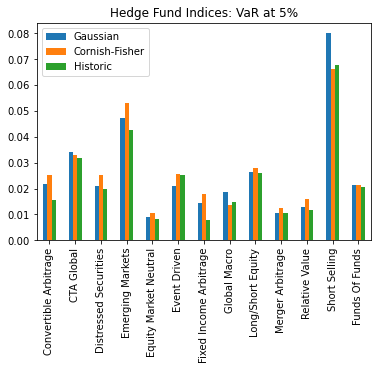

In [42]:
var_table = [ptk.var_gaussian(hfi), 
             ptk.var_gaussian(hfi, modified=True), 
             ptk.var_historic(hfi)]
comparison = pd.concat(var_table, axis=1)
comparison.columns=['Gaussian', 'Cornish-Fisher', 'Historic']
comparison.plot.bar(title="Hedge Fund Indices: VaR at 5%")

Note that in some cases, the cornish-fisher VaR is lower i.e. estimates a smaller loss than you would get from a pure gaussian assumption. That can happen if the observed skewness is positive, as is the case for "Short Selling" and "Global Macro"

In [43]:
ptk.skewness(hfi)

Convertible Arbitrage    -2.639592
CTA Global                0.173699
Distressed Securities    -1.300842
Emerging Markets         -1.167067
Equity Market Neutral    -2.124435
Event Driven             -1.409154
Fixed Income Arbitrage   -3.940320
Global Macro              0.982922
Long/Short Equity        -0.390227
Merger Arbitrage         -1.320083
Relative Value           -1.815470
Short Selling             0.767975
Funds Of Funds           -0.361783
dtype: float64